# Modules and settings

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima # incompatible with latest numpy
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
np.float_ = np.float64 # prophet fix
from prophet import Prophet

sns.set()
plt.rcParams["figure.figsize"] = (20,10)

# Import, clean, merge, split data

In [16]:
# Import data
data_generation1 = pd.read_csv('data/kaggle/datasets/solar-power-generation-data-anikannal-Plant_1_Generation_Data.csv')
data_weather1 = pd.read_csv('data/kaggle/datasets/solar-power-generation-data-anikannal-Plant_1_Weather_Sensor_Data.csv')

# Format dates
data_generation1['DATE_TIME'] = pd.to_datetime(data_generation1['DATE_TIME'], format='%d-%m-%Y %H:%M', dayfirst=True)
data_weather1['DATE_TIME'] = pd.to_datetime(data_weather1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Drop and group
data_generation1.drop(['PLANT_ID'], axis=1, inplace=True)
data_generation1 = data_generation1.groupby(['DATE_TIME']).sum().reset_index()
data_generation1.drop(['SOURCE_KEY'], axis=1, inplace=True)
data_weather1.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)

# Add hours and minutes, and relative time
data_generation1['HOUR_MINUTE'] = data_generation1['DATE_TIME'].dt.strftime('%H:%M')
data_generation1['HOUR'] = data_generation1['DATE_TIME'].dt.hour
data_generation1['MINUTE'] = data_generation1['DATE_TIME'].dt.minute
data_generation1['MINUTES_FROM_MIDDAY'] = abs((data_generation1['HOUR'] - 12) * 60 + data_generation1['MINUTE'])
# data_generation1['MINUTES_SINCE_MIDNIGHT'] = data_generation1['HOUR'] * 60 + data_generation1['MINUTE']
data_generation1.drop(['HOUR', 'MINUTE'], axis=1, inplace=True)

# Merge data
data_plant1 = pd.merge(data_generation1, data_weather1, how='outer', on=['DATE_TIME'], suffixes=('_generation', '_weather'))
# data_plant1.reset_index(drop=True, inplace=True)

# Deal with nulls
# print('Deal with nulls')
# print(data_plant1.isnull().sum())
# print(data_plant1[data_plant1.isnull().any(axis=1)])
data_plant1 = data_plant1.dropna(axis=0)

# print('Processed data')
# print(data_plant1.head(1))
# print()
# print(data_plant1.tail(1))
# print()
# print(data_plant1.describe(include='all'))
# print()

# Split data into two halves
unique_dates = data_plant1['DATE_TIME'].dt.date.unique()
unique_dates_n = len(unique_dates)
# unique_dates.sort()
days_for_split = math.ceil(unique_dates_n/2)
dates_first_half = unique_dates[:days_for_split]
dates_second_half = unique_dates[days_for_split:]
data_plant1_first_half = data_plant1[data_plant1['DATE_TIME'].dt.date.isin(dates_first_half)].copy()
data_plant1_second_half = data_plant1[data_plant1['DATE_TIME'].dt.date.isin(dates_second_half)].copy()

# print('Split data')
# print(f'Unique dates: {unique_dates_n}')
# print(f"First half: {data_plant1_first_half.iloc[0]['DATE_TIME']} to {data_plant1_first_half.iloc[-1]['DATE_TIME']}")
# print(f"Second half: {data_plant1_second_half.iloc[0]['DATE_TIME']} to {data_plant1_second_half.iloc[-1]['DATE_TIME']}")
# print()

# Old stuff
# data_weather1 = data_weather1.groupby(['DATE_TIME']).mean().reset_index()
# data_generation1.set_index('DATE_TIME', inplace=True)
# data_weather1.set_index('DATE_TIME', inplace=True)
# print(data_generation1.head(1).to_string(index=False, line_width=1000))
# data_plant1 = data_plant1[['DATE_TIME', 'HOUR_MINUTE', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

# Plot

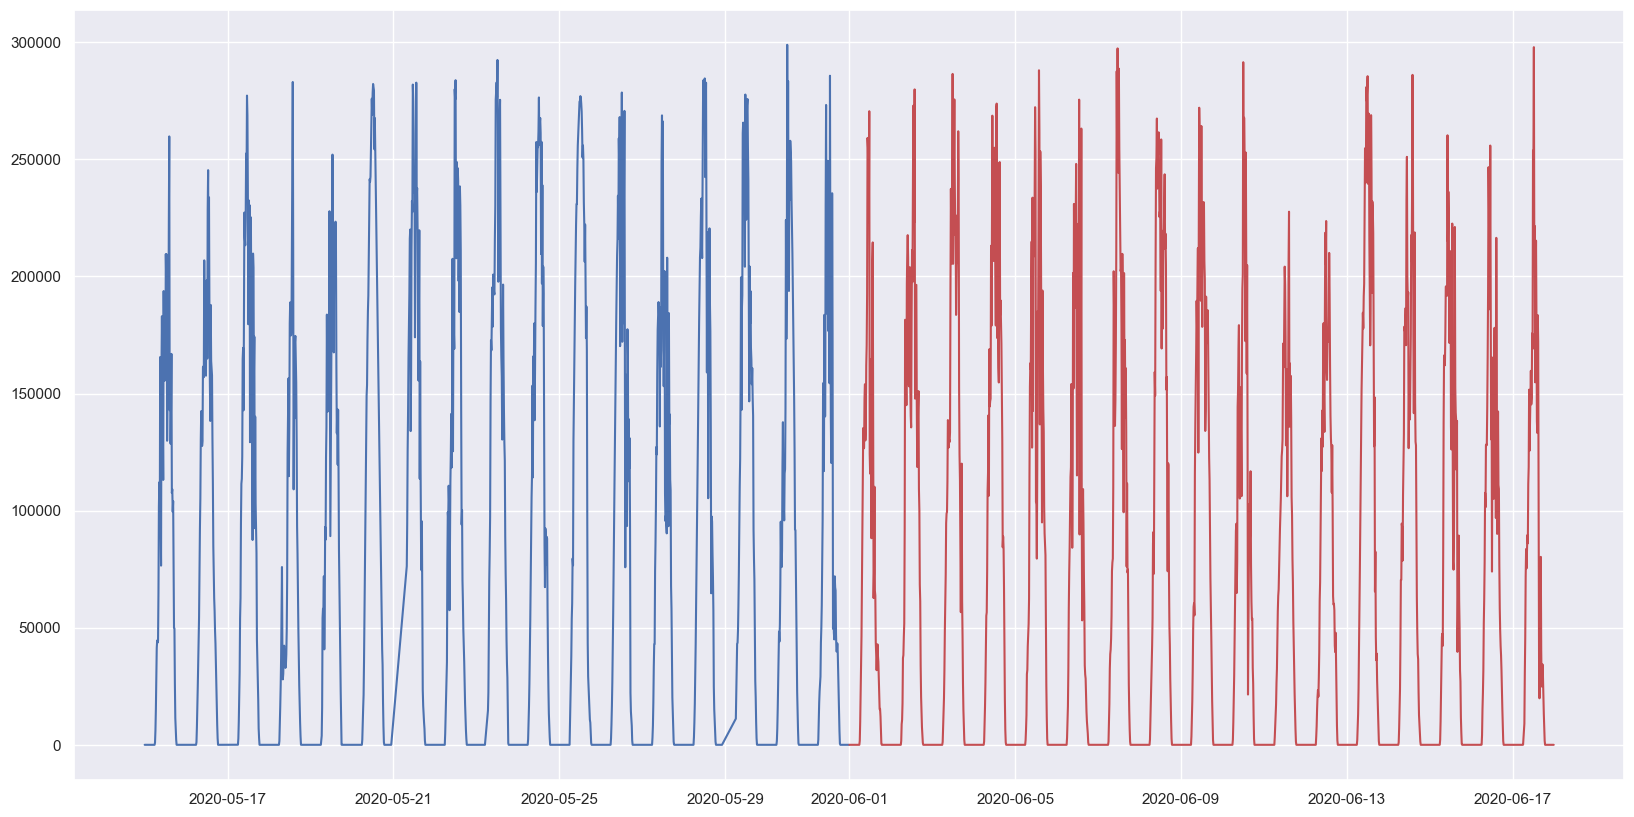

In [17]:
x = data_plant1_first_half['DATE_TIME']
y = data_plant1_first_half['DC_POWER']
plt.plot(x,y,c='b')
x = data_plant1_second_half['DATE_TIME']
y = data_plant1_second_half['DC_POWER']
plt.plot(x,y,c='r')
plt.show()

# Daily sums and averages

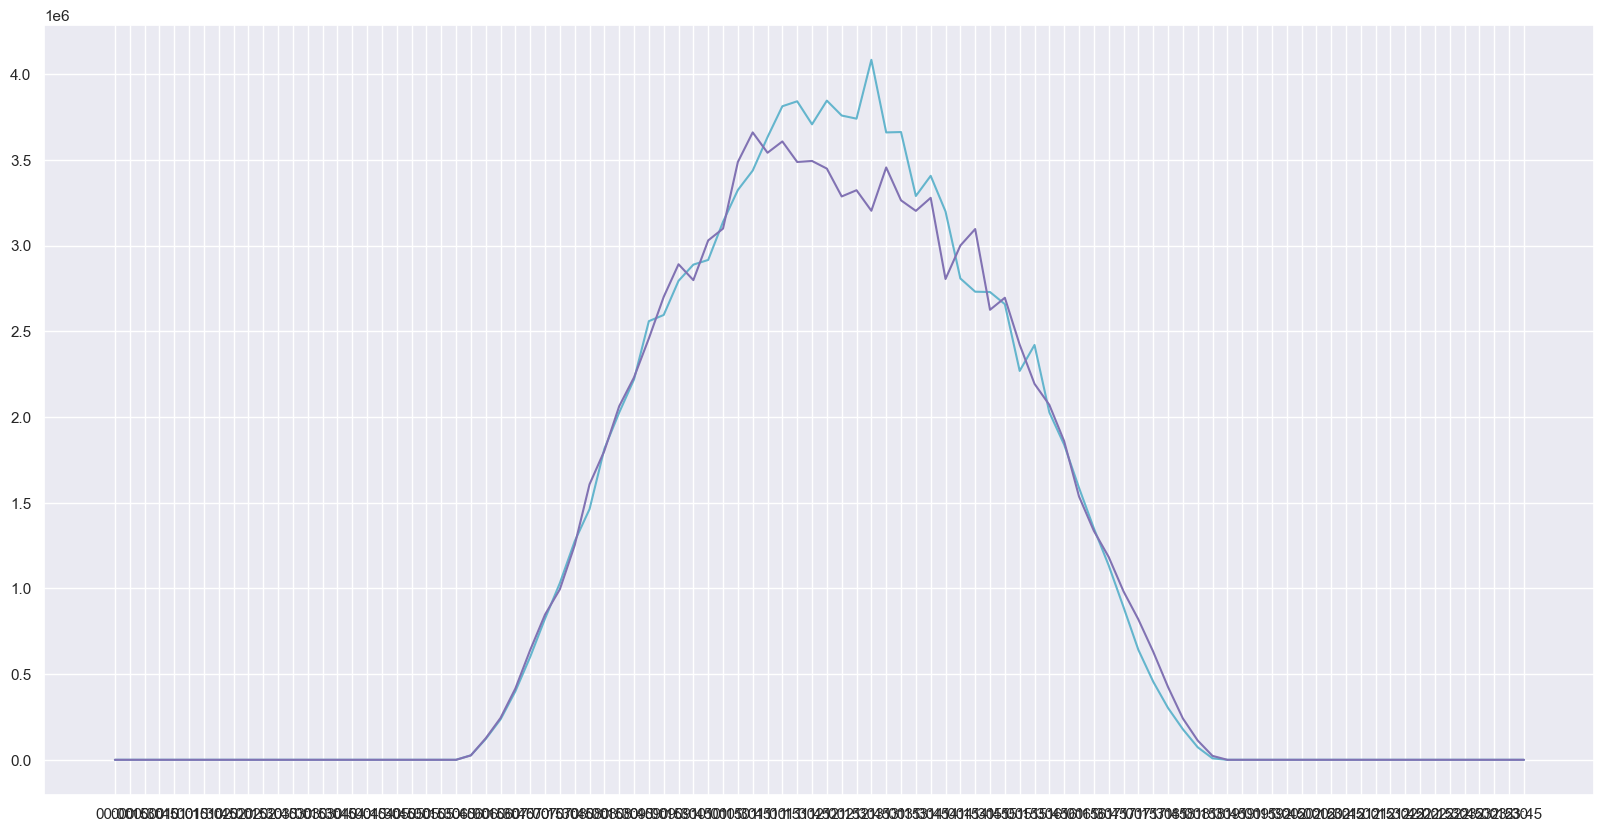

In [18]:
scaler = MinMaxScaler()

# Averages, scaled
# data_plant1_first_half_avg = data_plant1_first_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').mean().reset_index()
# data_plant1_second_half_avg = data_plant1_second_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').mean().reset_index()

# x = data_plant1_first_half_avg['HOUR_MINUTE']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_first_half_avg[['DC_POWER']]))
# # y = data_plant1_first_half_avg['DC_POWER']
# plt.plot(x,y,c='b')

# x = data_plant1_second_half_avg['HOUR_MINUTE']
# # y = data_plant1_second_half_avg['DC_POWER']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_second_half_avg[['DC_POWER']]))
# plt.plot(x,y,c='r')

# Sums (scaled commented out)
data_plant1_first_half_sum = data_plant1_first_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').sum().reset_index()
data_plant1_second_half_sum = data_plant1_second_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').sum().reset_index()

x = data_plant1_first_half_sum['HOUR_MINUTE']
y = data_plant1_first_half_sum['DC_POWER']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_first_half_sum[['DC_POWER']]))
plt.plot(x,y,c='c')

x = data_plant1_second_half_sum['HOUR_MINUTE']
y = data_plant1_second_half_sum['DC_POWER']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_second_half_sum[['DC_POWER']]))
plt.plot(x,y,c='m')

# Show plot
plt.show()

# Scatter and histogram

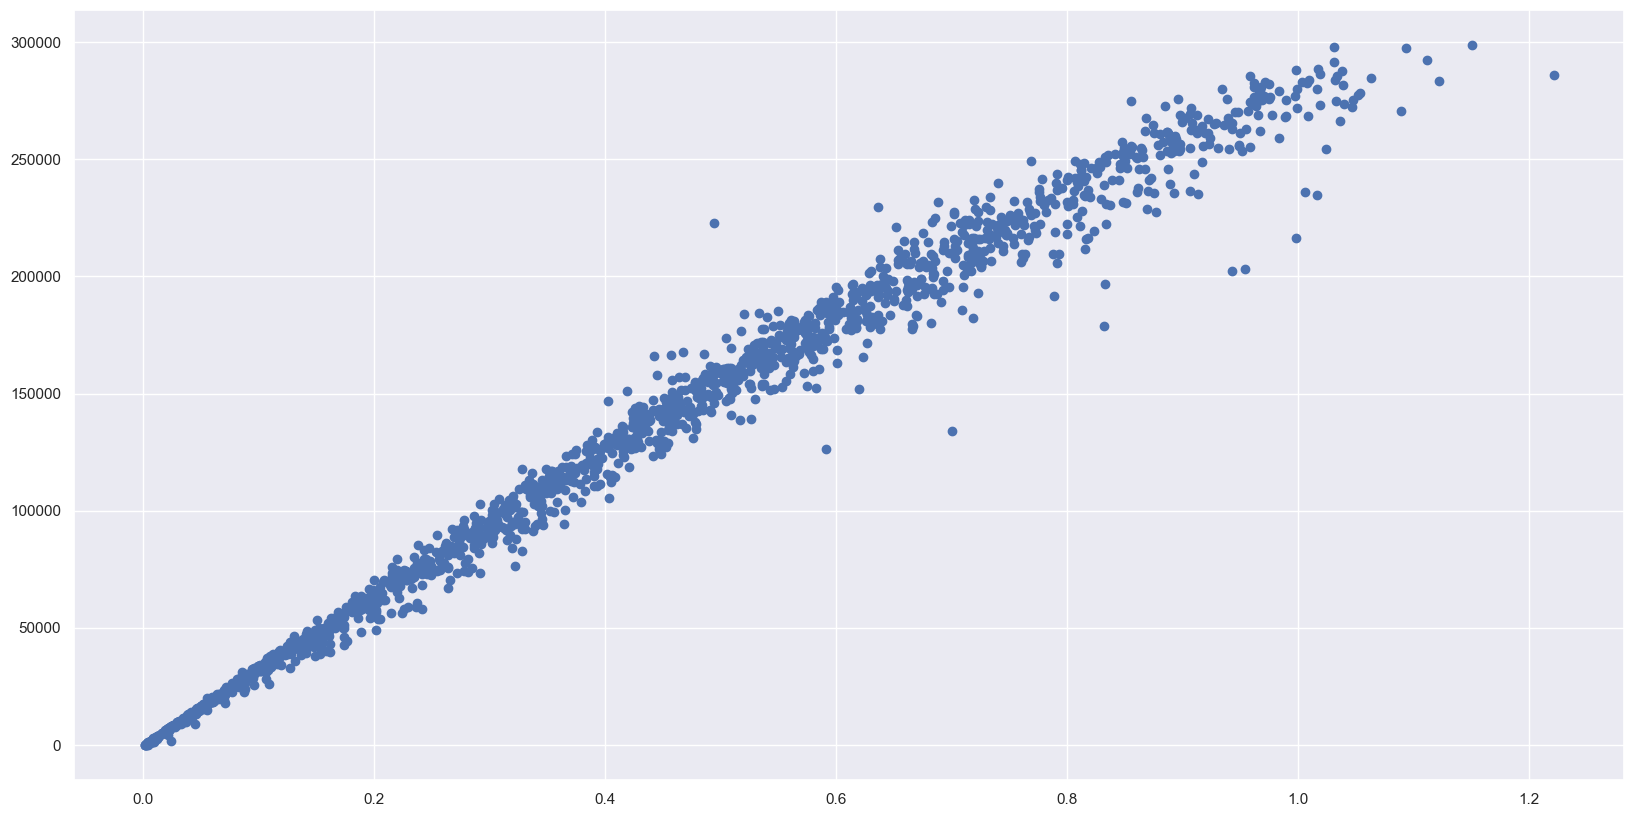

In [19]:
data_plant1_active = data_plant1[data_plant1['IRRADIATION']>0]
data_plant1_active = data_plant1[data_plant1['DC_POWER']>0]
# x = data_plant1_active['AMBIENT_TEMPERATURE'] # weak correlation
# x = data_plant1_active['MINUTES_FROM_MIDDAY'] # weak correlation
x = data_plant1_active['IRRADIATION'] # strong correlation
y = data_plant1_active['DC_POWER']
plt.scatter(x,y)
plt.show()

<Axes: xlabel='DC_POWER', ylabel='Count'>

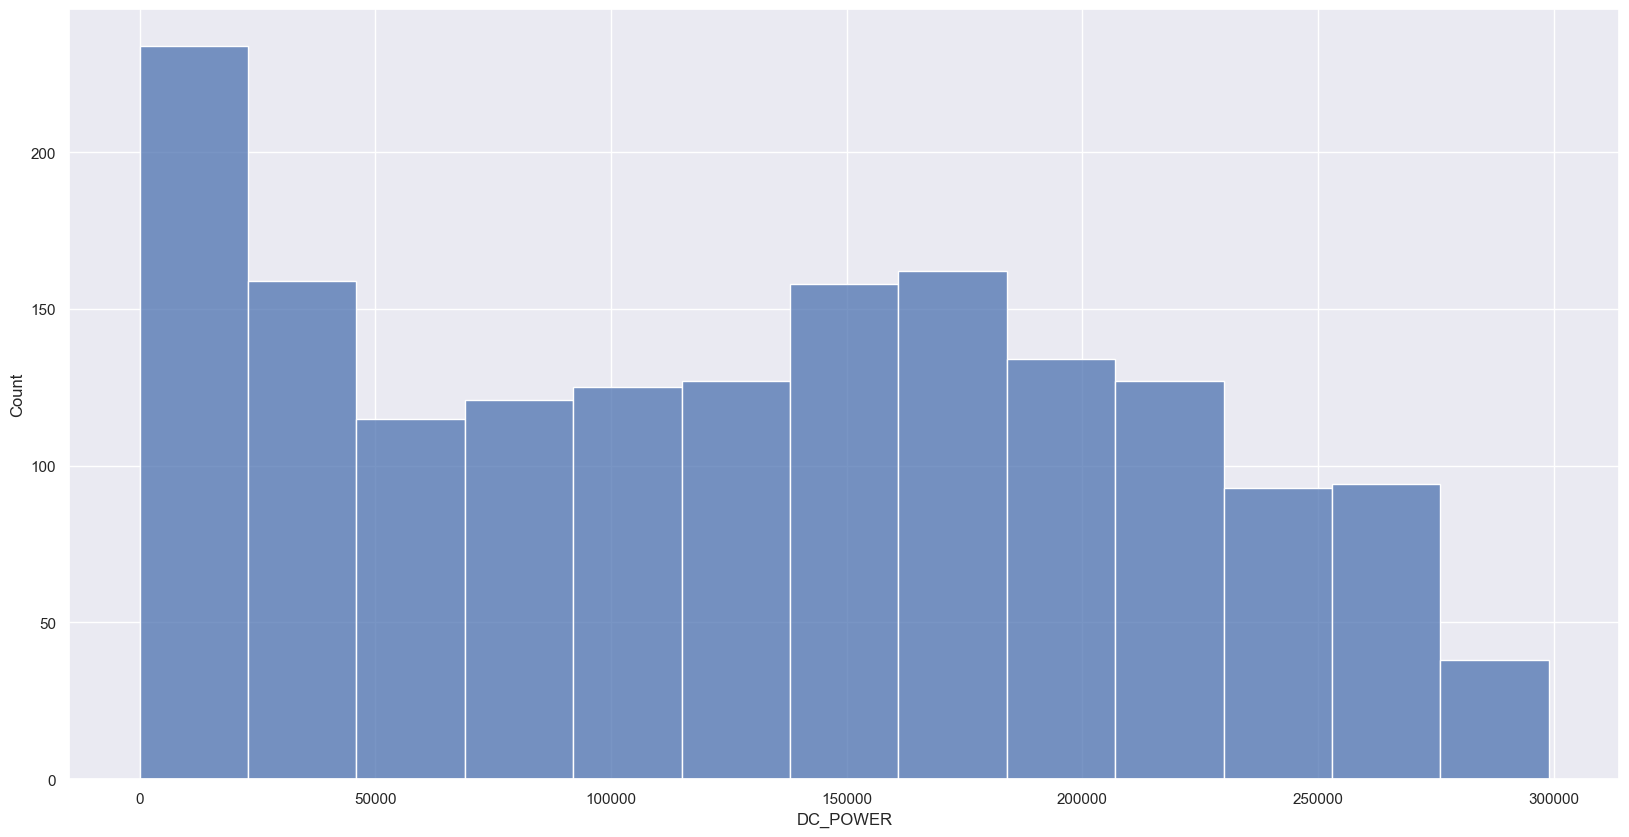

In [20]:
sns.histplot(data_plant1_active['DC_POWER'])

# Linear Regression

## VIF and remove multicollinearity

In [21]:
# variables = data_plant1[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD',
       # 'MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE',
       # 'MODULE_TEMPERATURE', 'IRRADIATION']]
variables = data_plant1[['MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
print(vif)
data_plant1_nmc = data_plant1[['DC_POWER', 'MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]

         VIF             features
0  10.074464  MINUTES_FROM_MIDDAY
1  17.924584  AMBIENT_TEMPERATURE
2   6.341700          IRRADIATION


## Model using train_test_split

### No scaling

Training data length: 1578
Testing data length: 1579

              Features        Weights
0  MINUTES_FROM_MIDDAY     -19.285439
1  AMBIENT_TEMPERATURE     269.103175
2          IRRADIATION  275220.422362

Mean Squared Error: 64869951.5486149
R^2 Score: 0.9910379203249323



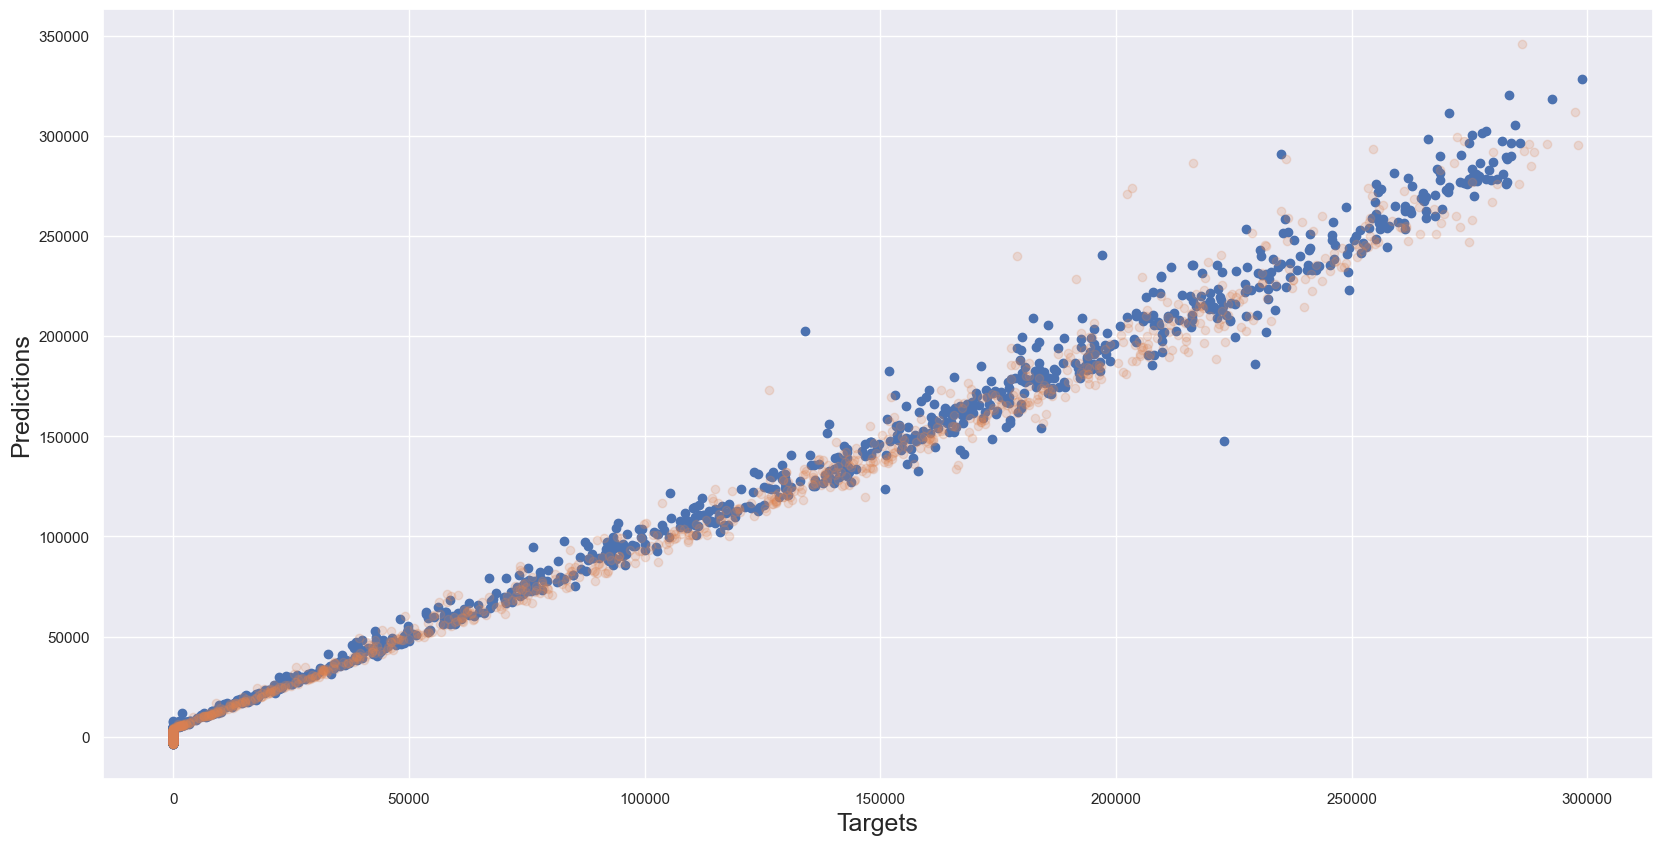

In [22]:
targets = data_plant1_nmc['DC_POWER']
inputs = data_plant1_nmc.drop(['DC_POWER'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.5, random_state=1, shuffle=False)

print(f'Training data length: {len(x_train)}')
print(f'Testing data length: {len(x_test)}')
print()

model = LinearRegression()
model.fit(x_train,y_train)

model_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
model_summary['Weights'] = model.coef_
print(model_summary)
print()

y_hat = model.predict(x_train)
plt.scatter(y_train, y_hat)

y_hat_test = model.predict(x_test)
plt.scatter(y_test, y_hat_test, alpha=0.2)

mse = mean_squared_error(y_test, y_hat_test)
r2 = r2_score(y_test, y_hat_test)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print()

plt.xlabel('Targets', size=18)
plt.ylabel('Predictions', size=18)
# plt.show()
plt.savefig('noscale.png')

### Scaled

Training data length: 1578
Testing data length: 1579

              Features       Weights
0  MINUTES_FROM_MIDDAY  -4000.159248
1  AMBIENT_TEMPERATURE    901.637830
2          IRRADIATION  82924.101116

Mean Squared Error: 64869951.548614286
R^2 Score: 0.9910379203249324



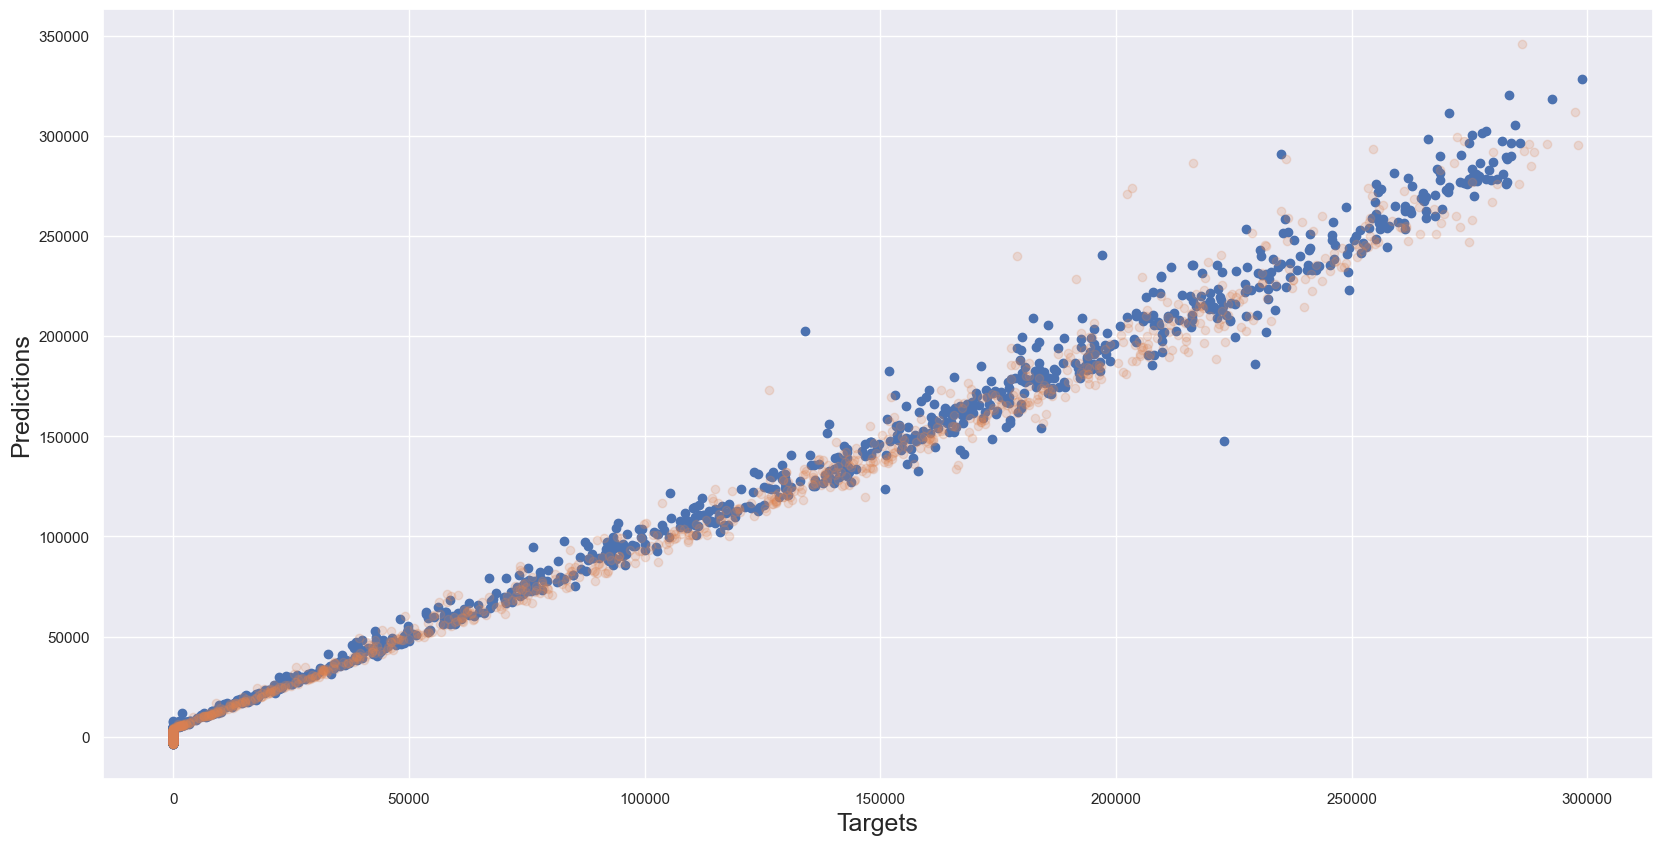

In [23]:
targets = data_plant1_nmc['DC_POWER']
inputs = data_plant1_nmc.drop(['DC_POWER'],axis=1)

scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.5, random_state=1, shuffle=False)

print(f'Training data length: {len(x_train)}')
print(f'Testing data length: {len(x_test)}')
print()

model = LinearRegression()
model.fit(x_train,y_train)

model_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
model_summary['Weights'] = model.coef_
print(model_summary)
print()

y_hat = model.predict(x_train)
plt.scatter(y_train, y_hat)

y_hat_test = model.predict(x_test)
plt.scatter(y_test, y_hat_test, alpha=0.2)

mse = mean_squared_error(y_test, y_hat_test)
r2 = r2_score(y_test, y_hat_test)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print()

plt.xlabel('Targets', size=18)
plt.ylabel('Predictions', size=18)
# plt.show()
plt.savefig('scale.png')

## Model using my split

Training data length: 1528
Testing data length: 1629

              Features        Weights
0  MINUTES_FROM_MIDDAY     -18.186165
1  AMBIENT_TEMPERATURE     228.176576
2          IRRADIATION  276743.682606

Mean Squared Error: 69942051.88612549
R^2 Score: 0.9903447237481524



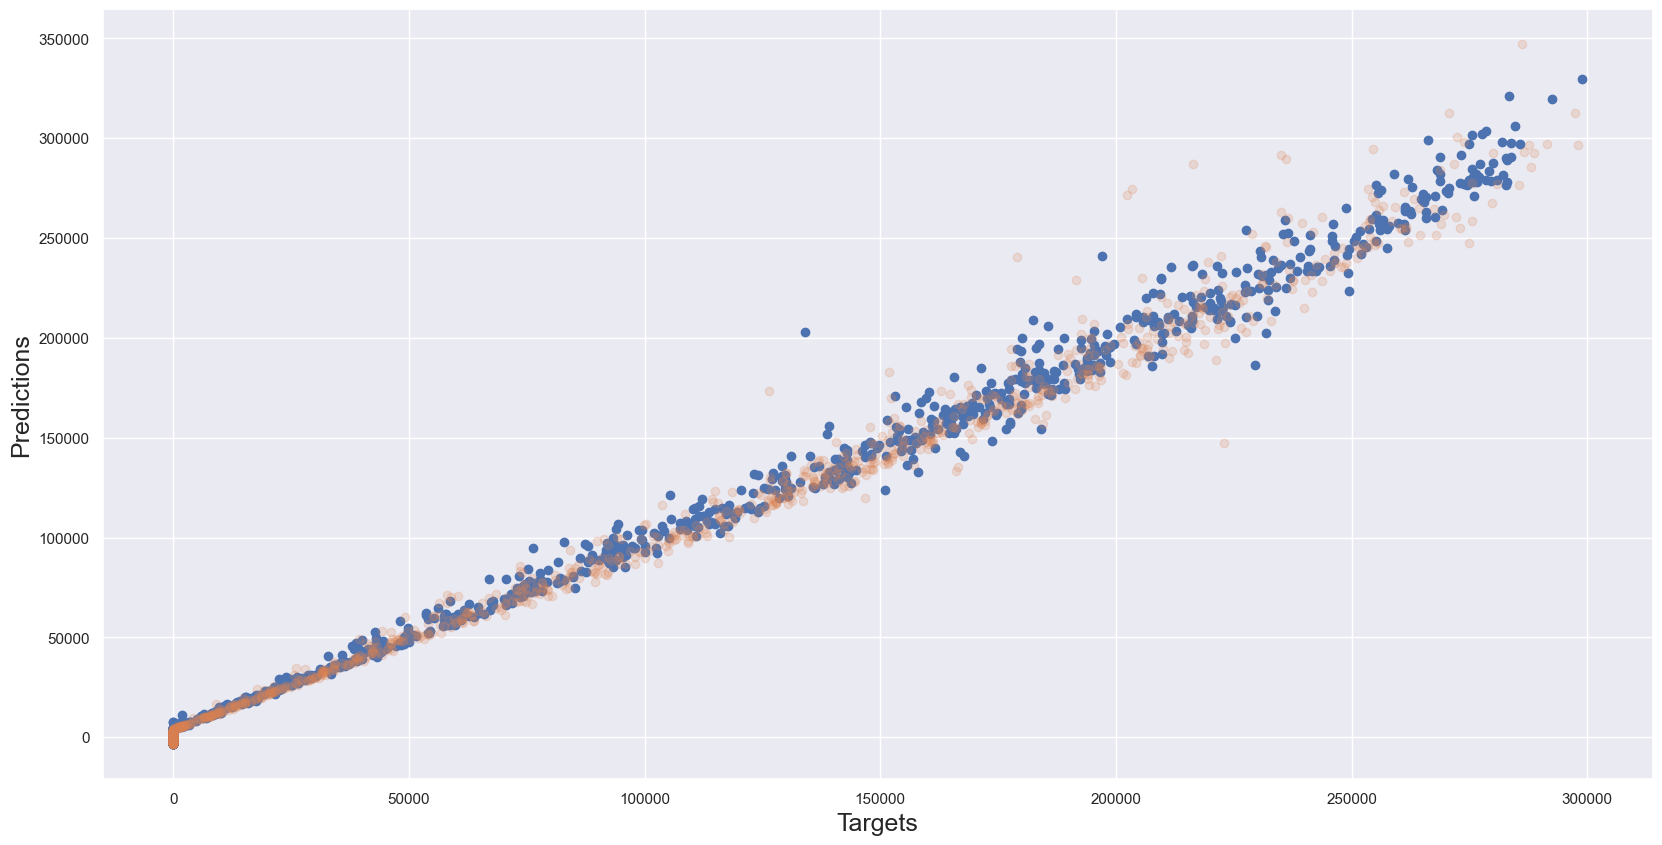

In [24]:
X_train = data_plant1_first_half[['MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]
y_train = data_plant1_first_half['DC_POWER']
X_test = data_plant1_second_half[['MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]
y_test = data_plant1_second_half['DC_POWER']

print(f'Training data length: {len(X_train)}')
print(f'Testing data length: {len(X_test)}')
print()

model = LinearRegression()
model.fit(X_train, y_train)

model_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
model_summary['Weights'] = model.coef_
print(model_summary)
print()

y_hat = model.predict(X_train)
plt.scatter(y_train, y_hat)

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.2)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print()

plt.xlabel('Targets', size=18)
plt.ylabel('Predictions', size=18)
# plt.show()
plt.savefig('mysplit.png')

# Forecast

In [25]:
data_for_forecasting = data_plant1[['DATE_TIME','DC_POWER']]
data_for_forecasting.set_index('DATE_TIME', inplace=True)
data_for_forecasting = data_for_forecasting.resample('15min').mean()
data_for_forecasting

,DC_POWER
DATE_TIME,
2020-05-15 00:00:00,0.0
2020-05-15 00:15:00,0.0
2020-05-15 00:30:00,0.0
2020-05-15 00:45:00,0.0
2020-05-15 01:00:00,0.0
...,...
2020-06-17 22:45:00,0.0
2020-06-17 23:00:00,0.0
2020-06-17 23:15:00,0.0


## ARIMA

C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


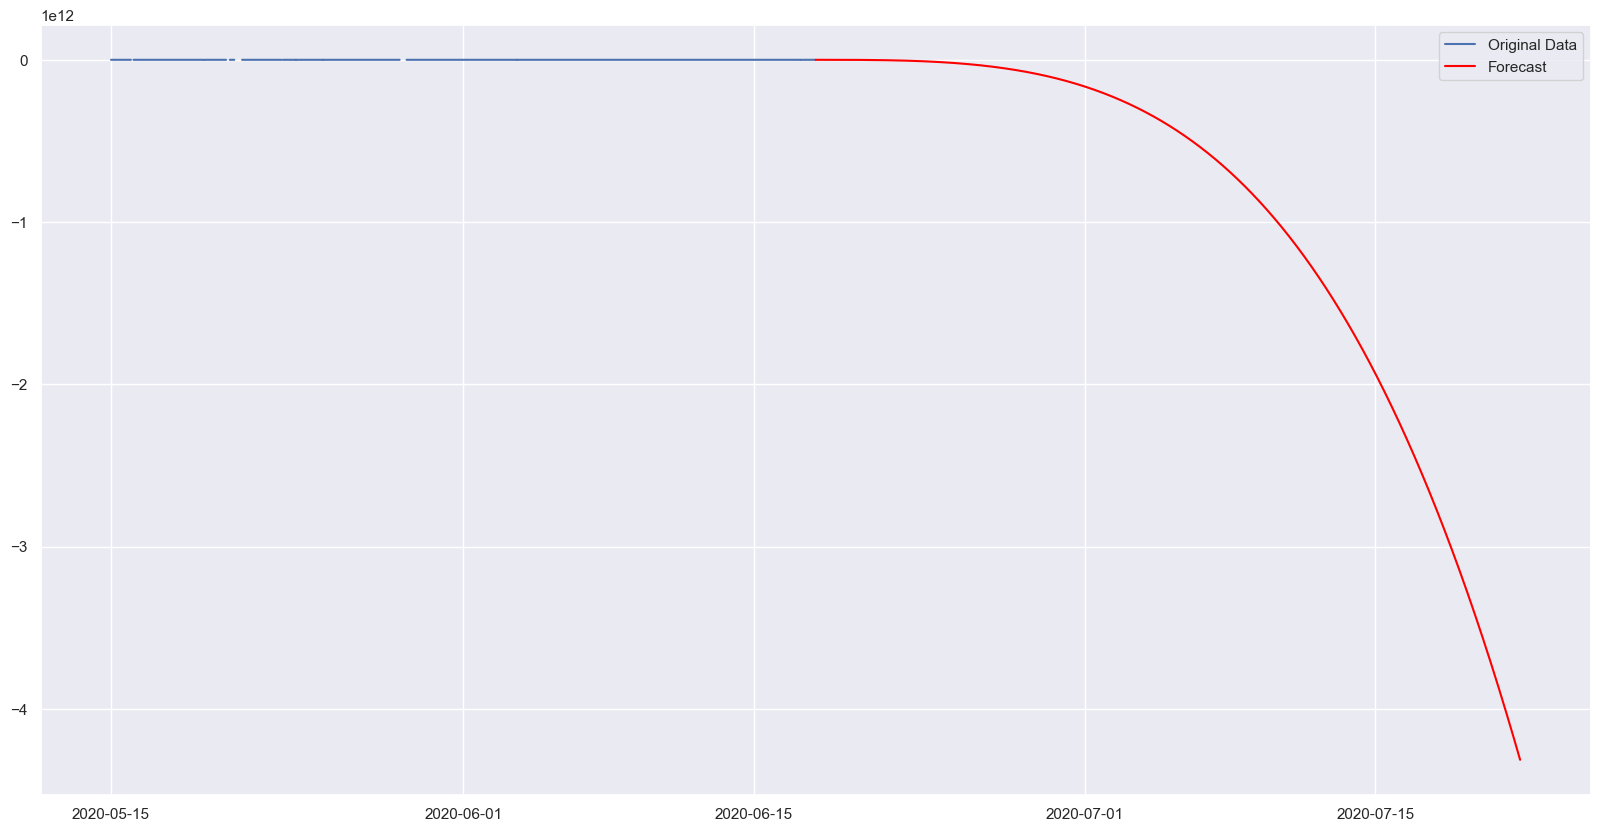

In [26]:
model = ARIMA(data_for_forecasting, order=(5,5,5))  # Adjust (p,d,q) depending on your data
model_fit = model.fit()

forecast = model_fit.forecast(steps=96*34) # 96 points per day for 34 days

plt.plot(data_for_forecasting, label='Original Data')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

## Prophet

13:03:24 - cmdstanpy - INFO - Chain [1] start processing
13:03:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


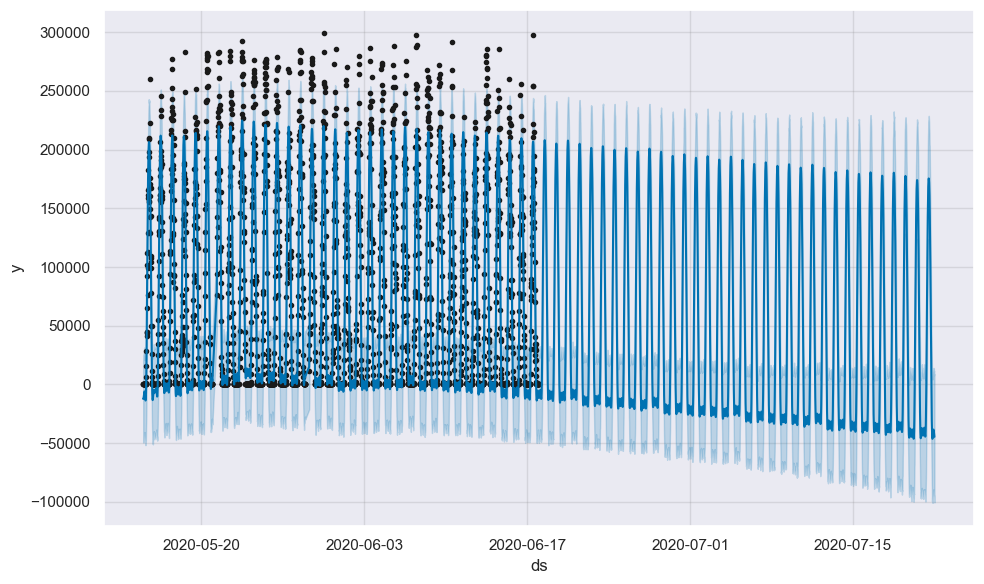

In [27]:
data_for_forecasting = data_for_forecasting.reset_index().rename(columns={'DATE_TIME': 'ds', 'DC_POWER': 'y'})  # adjust 'value' as needed
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(data_for_forecasting)
future = model.make_future_dataframe(periods=96*34, freq='15min')
forecast = model.predict(future)
model.plot(forecast)
plt.show()